# Community detection

In (Notebook X) we see from our network that nodes tend to bundle together in different groups. To identify some of these groups in a systematic way *community detection* serves as a useful tool. For this we use the *Louvain algorithm*. The Louvain algorithm relies on the network's *modularity* which is best described as a measure of how well a partitioned in the network can be split into supgraphs (communities). A higher modularity therefore corresponds to a better community structure. Formally the modularity can be expressed as ({cite}`barabasi2016network`):

$$
M = \sum^{n_c}_{c=1}\left[\frac{L_c}{L}-\left(\frac{k_c}{2L}\right)^{2}\right]
$$

where $n_c$ are the communities, $L_c$ are the number of links and  $k_c$ the total degree of nodes in the community $c$. The Louvain algorithm tries to find the communities that maximize $M$ by the following two steps {cite}`barabasi2016network`: 
1. First it assigns each node to its own communities, i.e. there are as many communities as nodes. Next, for each node $i$ we evaluate if by assigning it to one of its neighbours $j$ communities the change in modularity  $\Delta M$ is positive. Node $i$ then moves to the community of the neighbor that yields the highest positive change in $\Delta M$. This is repeated for all nodes until no further increase can be made.
2. In the second step, the algorithm creates a "super graph", that is each community is condensed into one node where the edges are now weighted by the total number of links going from one community to the other in the original network. Having done this, we rerun the first step on the "super graph". 

The steps are done iteratively until the maximum $M$ has been reached. As this is an approximate method it is not ensured that the algorithm will always find the global maximum $M$, all though that tests shows, that the algorithm usually is fairly accurate {cite}`findcommunities`.

In [2]:
import pickle
import pandas as pd
import community
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
from tqdm.notebook import tqdm
from typing import List
from collections import Counter, namedtuple, defaultdict
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_pickle('df_preprocessed.obj')
df["unigrams"] = df["tokens"].apply(lambda x: ast.literal_eval(x))
def get_bigrams(unigram: list) -> list:
    return["_".join([unigram[i], unigram[i+1]]) for i,t in enumerate(unigram) if i != len(unigram)-1]
df["bigrams"] = df["unigrams"].apply(lambda x: get_bigrams(x))

In [3]:
edgelist = pd.read_pickle('edgelist_preprocessed.obj')
G = nx.Graph()
G.add_edges_from(edgelist) 

The Louvain algorithm found 21 communities
Modularity of network: 0.5852
Largest community consists of 794 nodes
Smallest community consists of 2 nodes
Mean community size 189.238 nodes


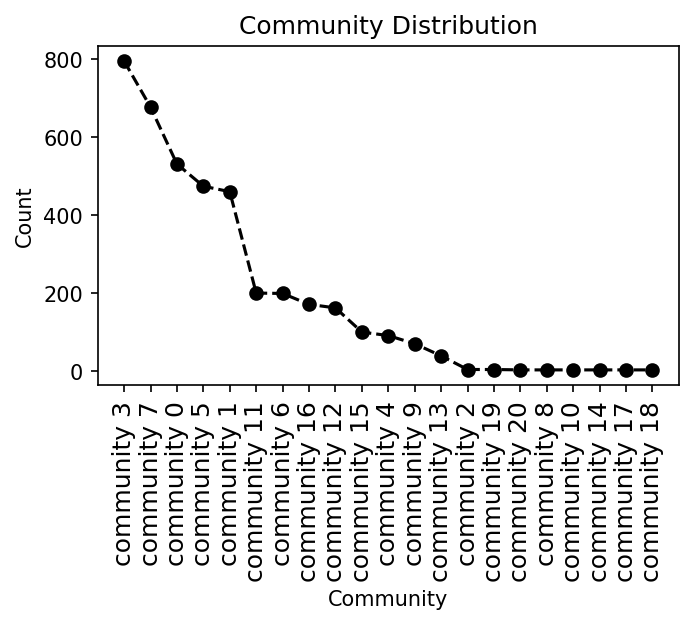

In [4]:
#Get Louvain partitions
partition = community.best_partition(G)
community_dist = Counter(partition.values())

print(f'The Louvain algorithm found {len(set(partition.values()))} communities')
print(f'Modularity of network: {np.round(community.modularity(partition,G), 4)}')
print(f'Largest community consists of {max(community_dist.values())} nodes')
print(f'Smallest community consists of {min(community_dist.values())} nodes')
print(f'Mean community size {np.round(np.mean(list(community_dist.values())),3)} nodes')

#Plot distribution
x = ['community '+str(x) for x,y in community_dist.most_common()]
y = [y for x,y in community_dist.most_common()]
fig, ax = plt.subplots(dpi = 150, figsize=(5,3))
ax.plot(x, y, 'ko--')
ax.set_title('Community Distribution')
ax.set_ylabel('Count')
ax.set_xlabel('Community')
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
plt.xticks(rotation = 90, size=12)
plt.show()

# TF-IDF

In [5]:
def create_dfm(docs:List[List], min_df:int=0, 
               max_df:int=np.inf, idf:bool=False, 
               return_vocab=False)->np.array:
    """
    Creates document-feature matrix of size N (docs) x K (vocab size).
    args:
        docs(list[list]): a list of documents where a document is a list of tokens.
        max_df(int): maximum freq allowed for a token in a document
        min_df(int): minimum freq required for a token in a document
        idf(bool): calculate the iverse document frequency (idf) else raw count
    returns:
        dfm(np.array): the NxK dfm
        vocab(list): vocab of unique tokens
    """
    #Remove very common or uncommon words
    if min_df != 0 or max_df != np.inf:
        temp = []
        for doc in docs:
            word_freq = Counter(doc)
            temp.append([w for w in doc if word_freq[w] >= min_df and 
                                           word_freq[w] <= max_df])
        docs = temp
        
    #Build the vocabulary and create index for each token
    vocab = list(set([w for doc in docs for w in doc]))
    vocab_size = len(vocab)
    tok2idx = {w:i for i,w in enumerate(vocab)}
    doc_n = len(docs)
    #Instantiate the dfm and add counts
    dfm = np.zeros([doc_n, vocab_size])
    for i,toks in enumerate(docs):
        for tok in toks:
            tok_idx = tok2idx[tok]
            dfm[i, tok_idx] += 1
    
    #Calculate tf and idf
    if idf:
        idf = np.sign(dfm)
        for i in range(doc_n):
            idf[i] = np.log((doc_n / idf.sum(axis = 0)))
        dfm *= idf
    
    if return_vocab:
        return dfm, vocab
    else:
        return dfm

#Add the corresponding community to each character in the Data frame
communites = []
obs = namedtuple('Obs', 'name Louvain_Community')
for n in df['name']:
    try:
        com = 'community_'+str(partition[n])
    except:
        com = np.nan
    communites.append(obs(n, com))
    
df = pd.merge(df, pd.DataFrame(communites), on='name')

#Get top6 communities
top6 = ['community_'+str(c[0]) for c in community_dist.most_common(6)]

#Subset data on top6 communities and groupby community. Extract the bigrams.
top6_df = df.loc[df['Louvain_Community']\
                  .isin(top6)].groupby('Louvain_Community')\
                  .agg({'unigrams':'sum',
                        'bigrams':'sum'})

# Token list with both unigrams and bigrams
tokens = top6_df.reset_index()["unigrams"] + top6_df.reset_index()["bigrams"]

#Create the document term frequency matrices for unigrams and bigrams. Token must appear min. 5 times
tf_idf, vocab = create_dfm(tokens, idf=True, return_vocab=True, min_df=5)

#Put into dataframes with vocab as colnames and community as index
tfidf_df = pd.DataFrame(tf_idf, columns=vocab, index = top6_df.index)

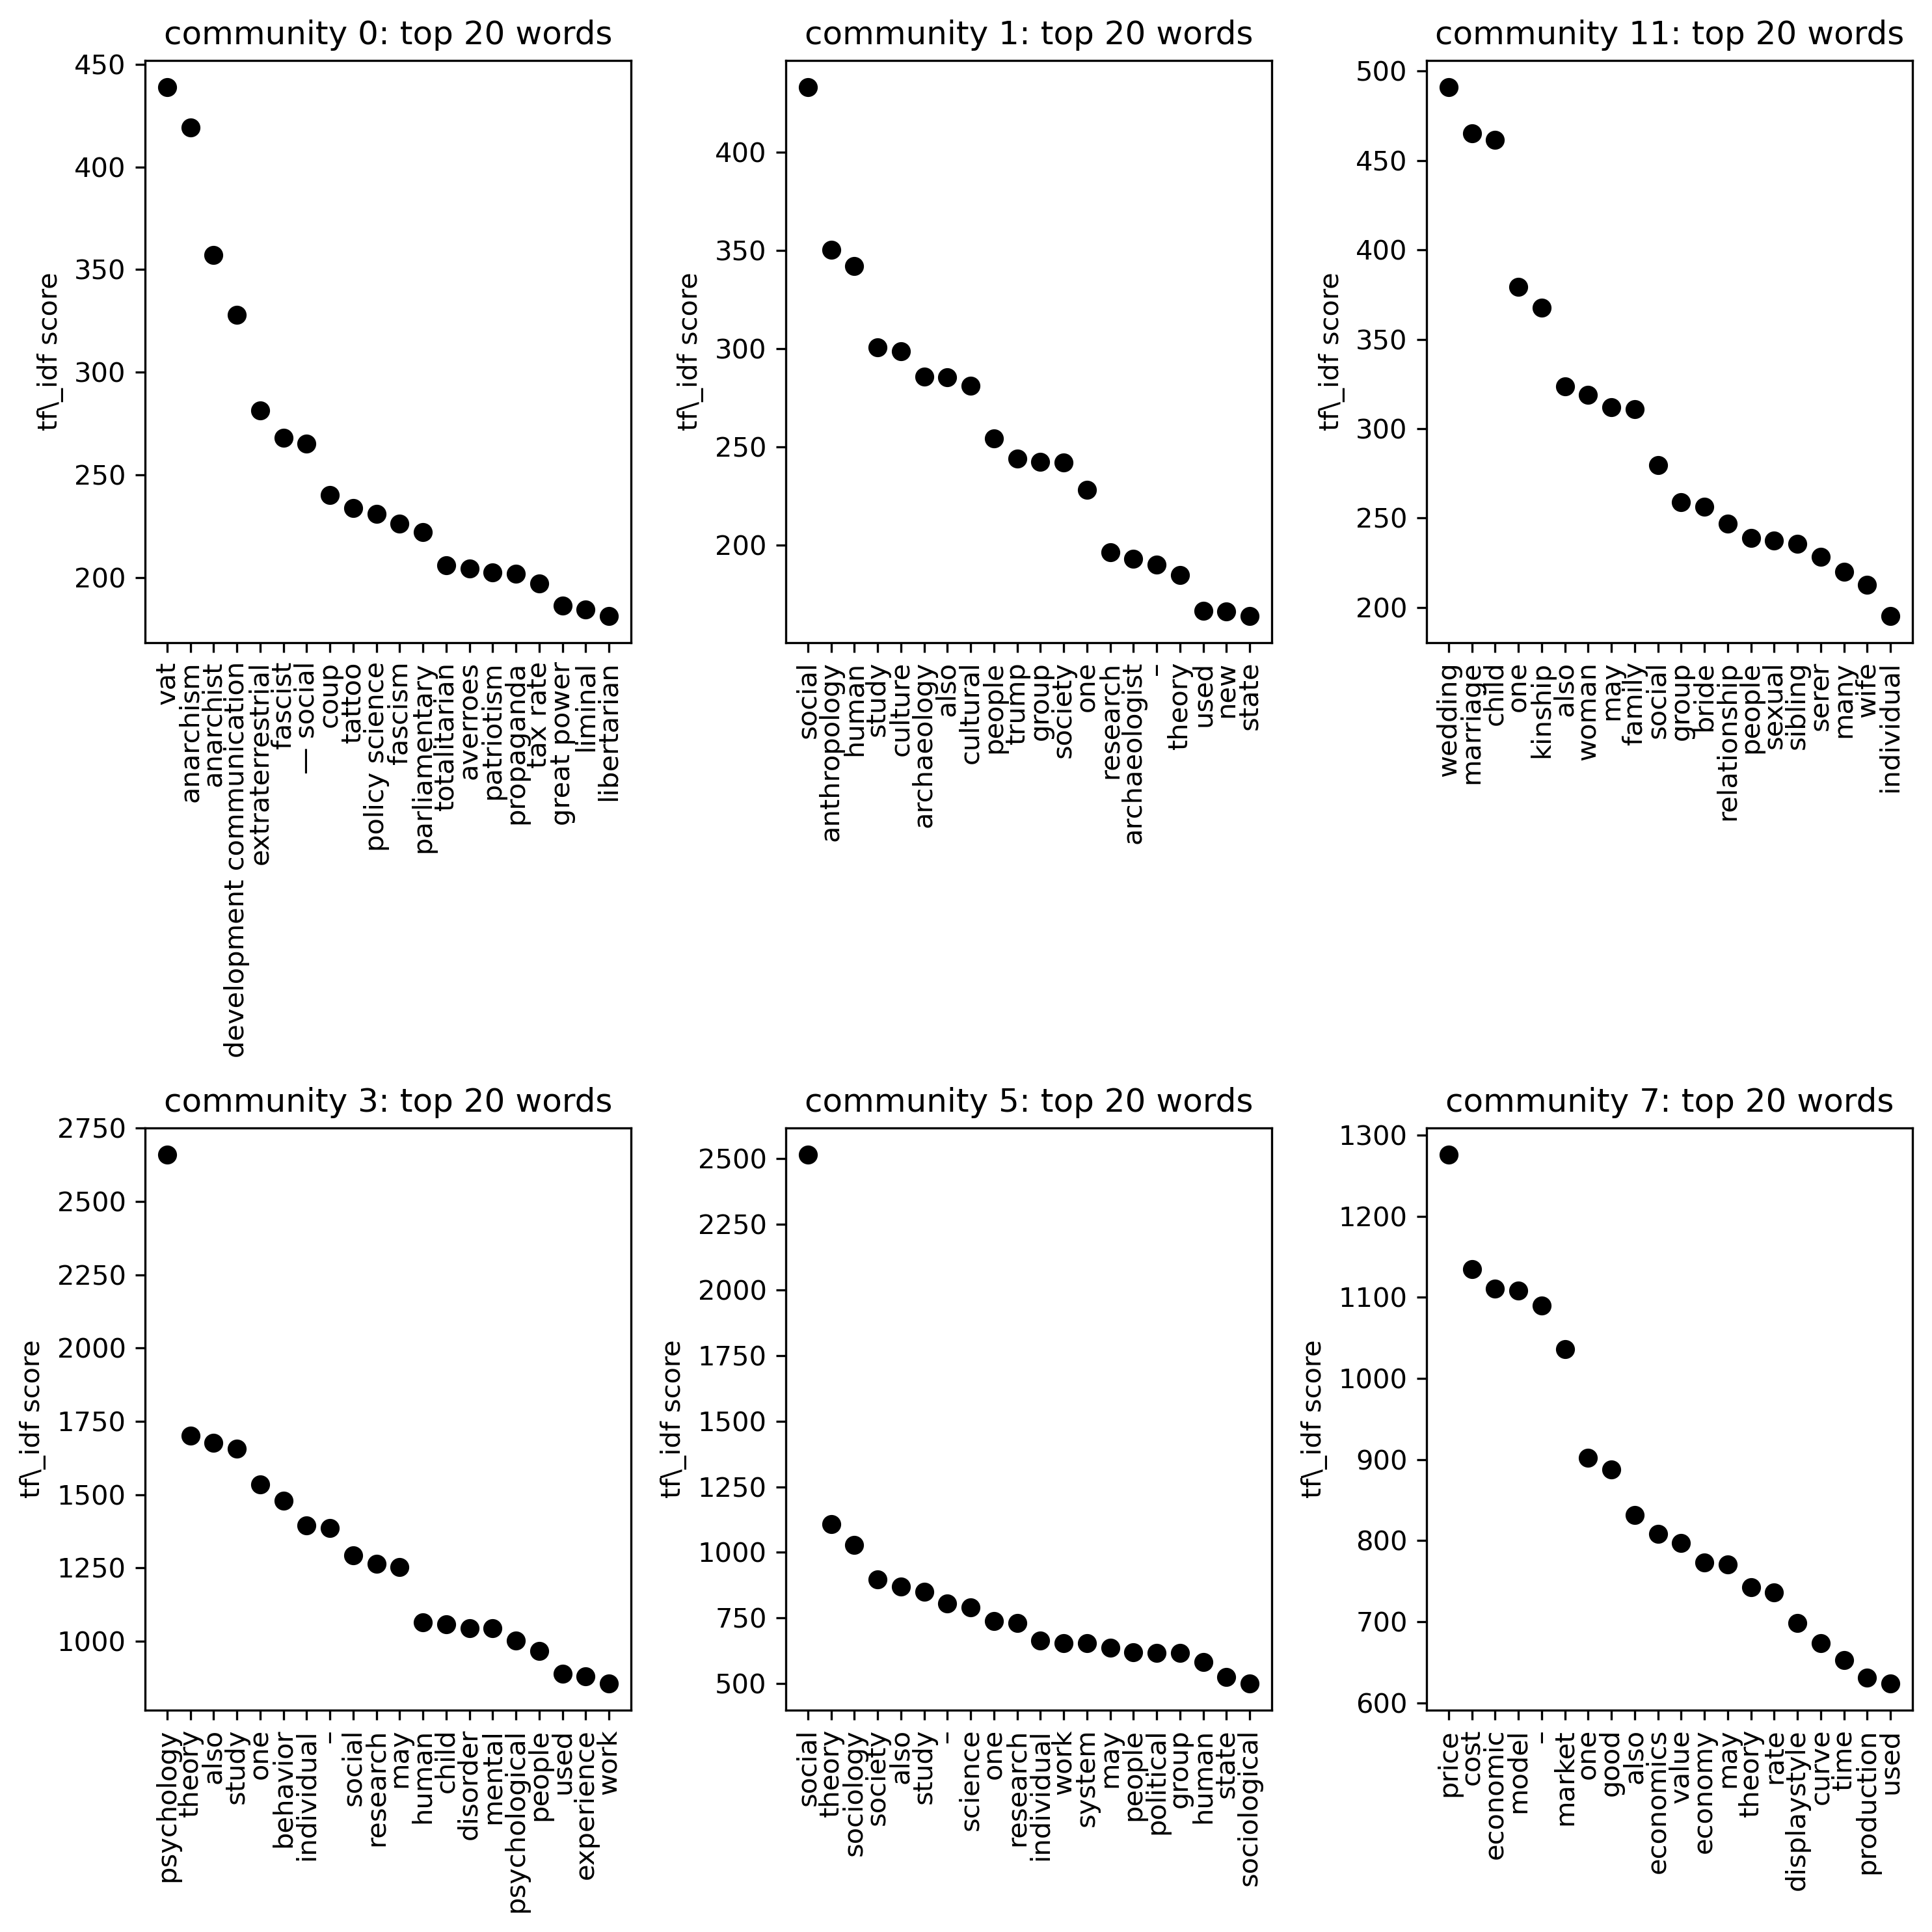

In [7]:
#Plot tf-idf
def plot_top_tfidf(df:pd.DataFrame=tfidf_df, n:int=20)->None:
    """
    Plots the n tokens with higest tf-idf score for the 6 most frequent communities
    """
    fig, axs = plt.subplots(nrows = 2, ncols=3, 
                            figsize = (10,10), dpi = 300)
    axs = axs.flat
    for i, row in enumerate(df.iterrows()):
        d = row[1].nlargest(n).to_dict()
        x = [n.replace('_', ' ') for n in d.keys()]
        y = d.values()
        axs[i].plot(x,y, 'ko')
        axs[i].set_title(df.index[i].replace('_', ' ') + f': top {n} words')
        axs[i].set_ylabel('tf\_idf score')
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].tick_params(axis='x', which='minor', bottom=False, top=False)
    plt.tight_layout()
    
plot_top_tfidf()

# Multinomial Logistic regression

In [8]:
# Lets take raw count
token_count, vocab = create_dfm(tokens, idf=False, return_vocab=True, min_df=10)
token_count_pd = pd.DataFrame(token_count, columns=vocab, index = top6_df.index)

In [9]:
def multinomial_logit_margins(x:np.array=token_count_pd.values,
                              y:np.array=token_count_pd.index.values,
                              vocab:list=vocab, p:int=2) -> pd.DataFrame:
    """
    Fits a multinomial logistic regression with LASSO penalty of size p.
    Then finds the average marginal effect for each feature for each y and append 
    it to a DataFrame. The model fits based on a x and y both being numpy arrays. 
    """
    fitted_model = LogisticRegression(multi_class='multinomial', 
                                      penalty='l1', 
                                      solver = "saga", 
                                      C= p,
                                      max_iter=10000).fit(x,y)
    betas = fitted_model.coef_
    probas = fitted_model.predict_proba(x)
    classes = fitted_model.classes_
    if len(classes) > 2:
        diff = betas[:,None] - np.dot(probas, betas)
        avg_margins = np.sum(probas * diff.T, axis=1) / probas.shape[0]
        avg_margins = pd.DataFrame(avg_margins, columns=classes)
        avg_margins["token"] = vocab
    return avg_margins

In [18]:
def plot_most_predictive_features(margins_df:pd.DataFrame, K:int=20):
    """
    Based on a DataFrame with the average marginal effect for a list of 
    features this function plots the K higest features for the different 
    classes.
    """
    fig, axs = plt.subplots(nrows = 2, ncols=3, figsize = (10,10), dpi = 300)
    axs = axs.flat
    community_features = {}
    for j, c in enumerate(margins_df.drop('token', axis=1).columns):
        community_features[c] = {margins_df["token"][i]: margins_df[c][i] for i in np.argpartition(margins_df[c],-K)[-K:]}
        community_features[c] = sorted(community_features[c].items(), key=lambda x: x[1], reverse=True)
        x = [i[0] for i in community_features[c]]
        y = [i[1] for i in community_features[c]]
        axs[j].plot(x, y,'ko')
        axs[j].set_title(f"{c.replace('_', ' ')}: {K} most predictive features \n", size = 10)
        axs[j].tick_params(axis='x', rotation=90)
        axs[j].tick_params(axis='x', which='minor', bottom=False, top=False)
    plt.tight_layout()

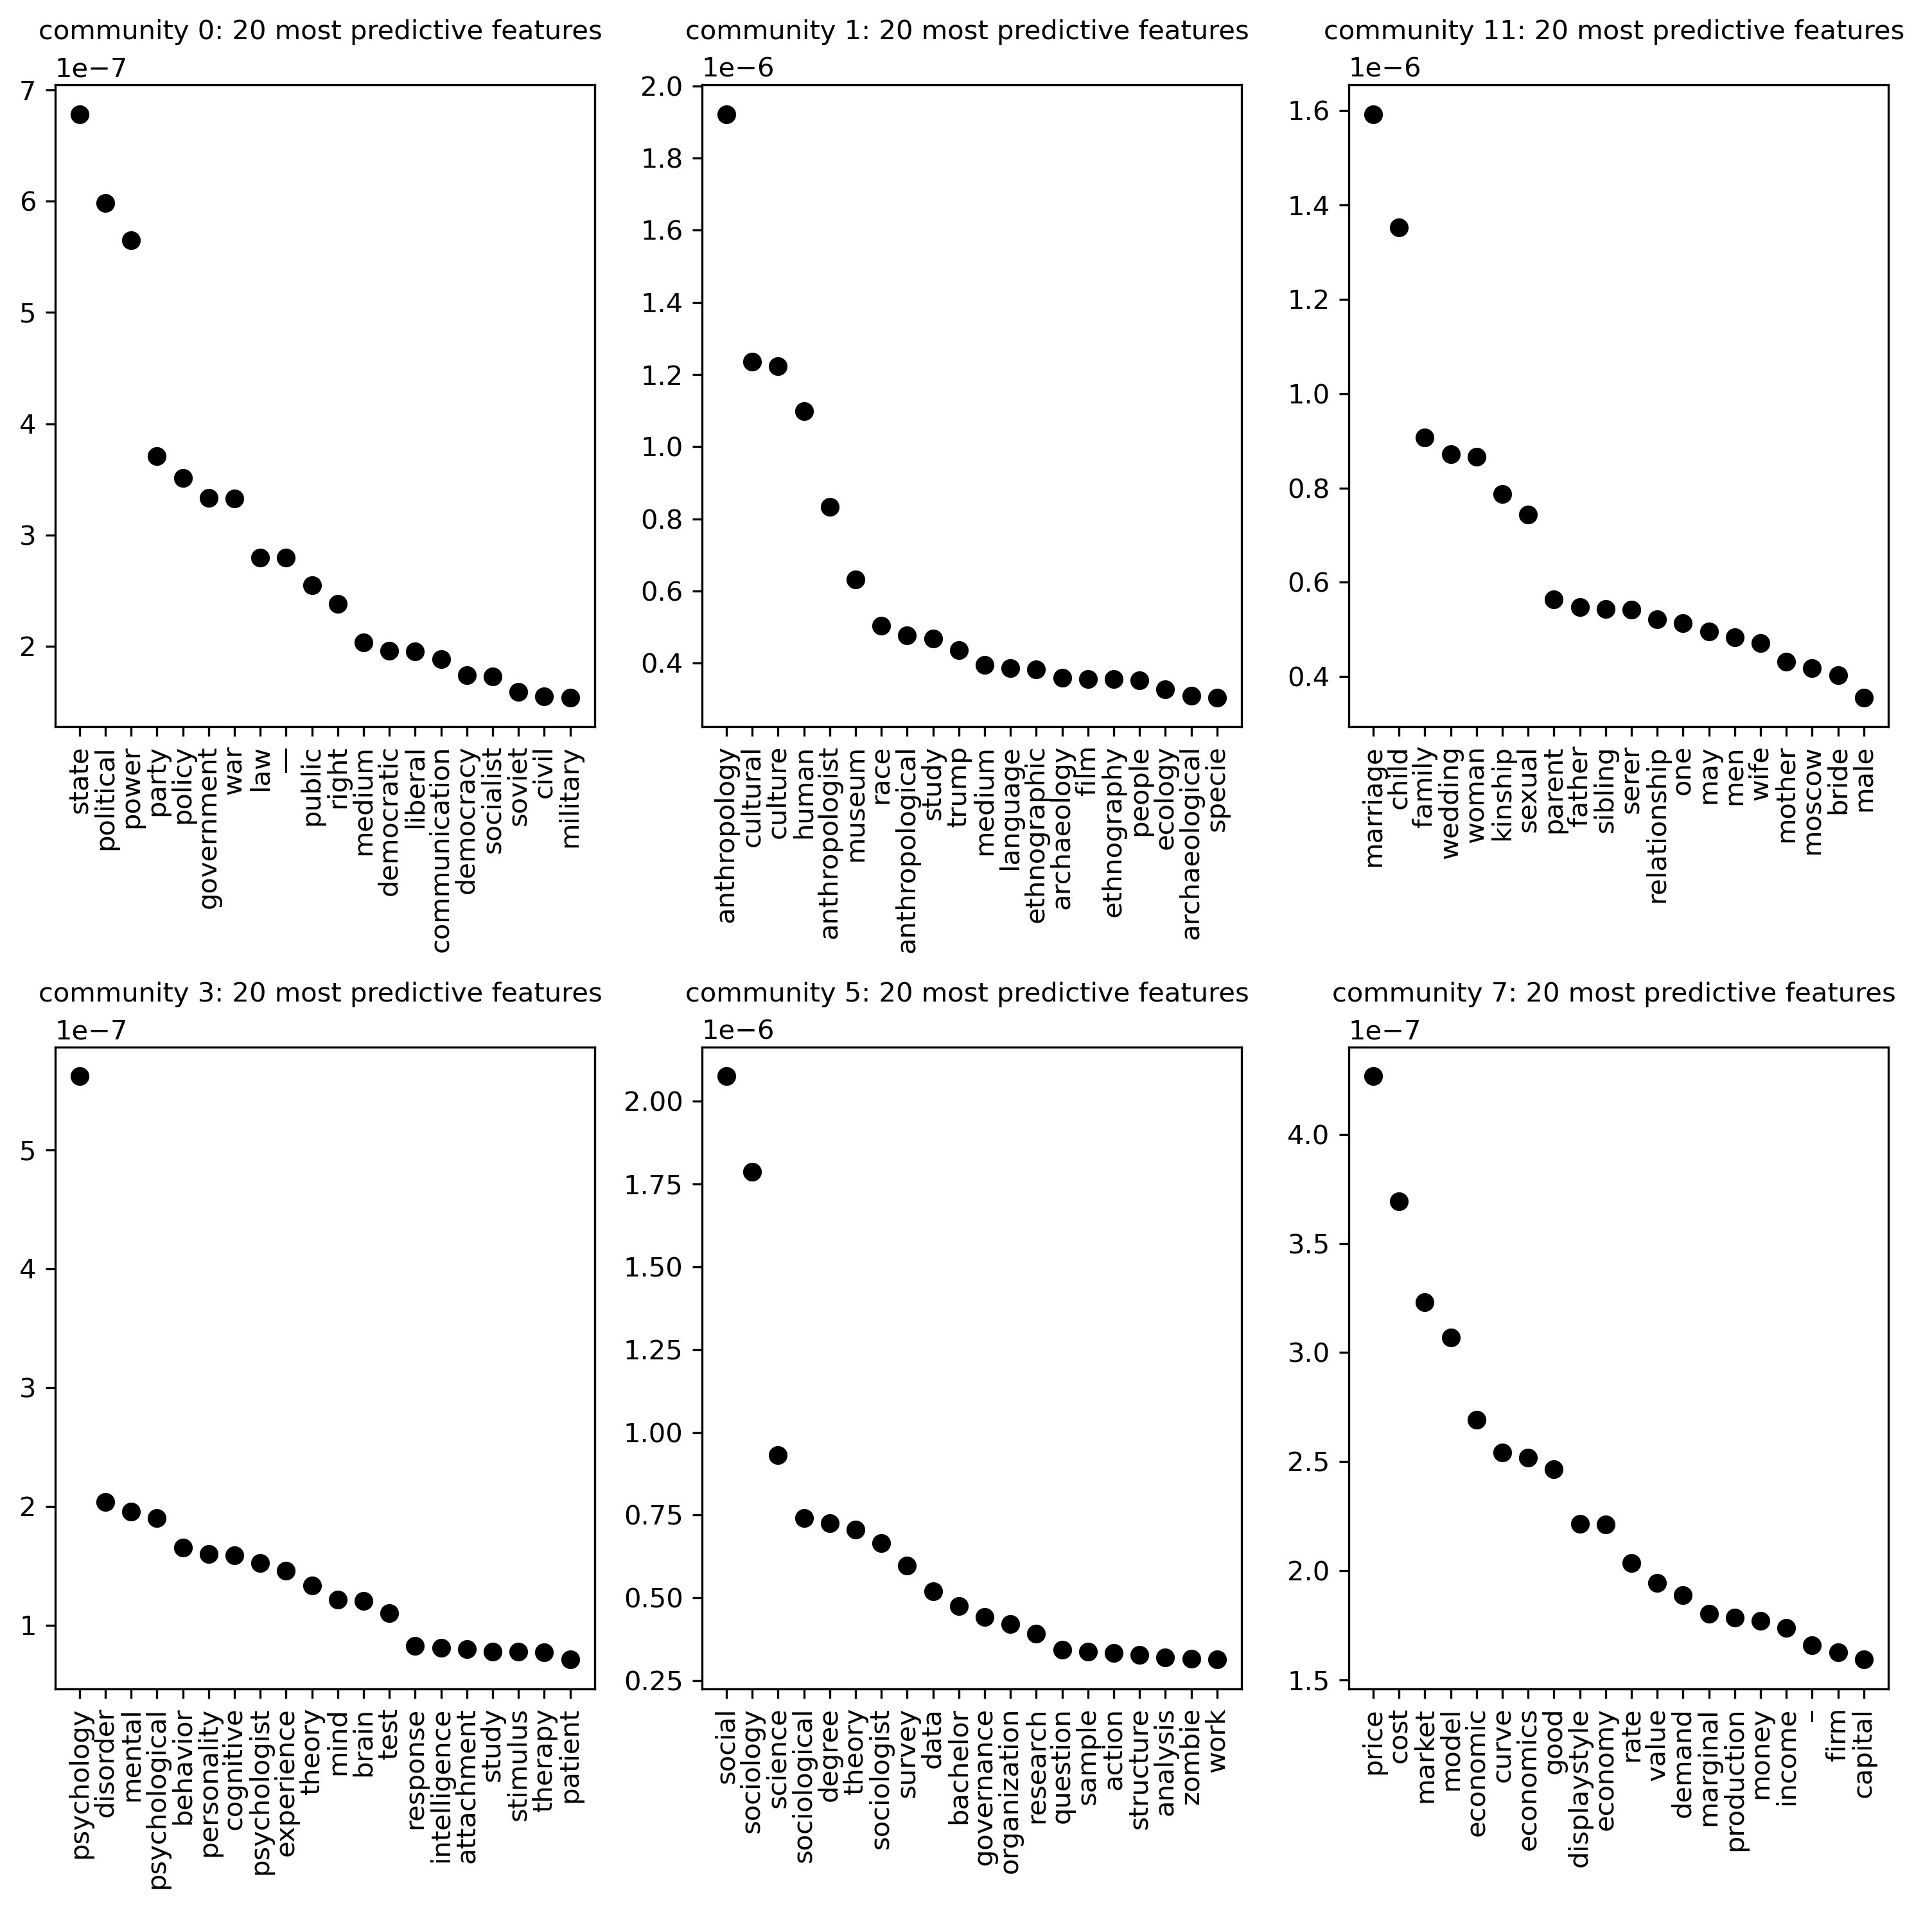

In [19]:
# We fit the multinomial_logit_margins() on our raw counts
margins_pd = multinomial_logit_margins()
# ... and plot our results
plot_most_predictive_features(margins_pd)

In [ ]:
"""
# If we want to bootstrap ci
def bootstrap_ci(tf=tf, n_prop:int=0.50, n_runs:int=100):
    statistics = [] 
    n_obs = tf.values.shape[1]
    n_size = int(n_obs * n_prop)
    print(f"Number of obs in bootstrap samples {n_size}...")
    start = time.time()
    for i in tqdm(range(n_runs)):
        #Draw random sample from X and y with replacement
        sample = tf.sample(n=n_size,axis='columns')
        x_sample = sample.values
        y_sample = sample.index.values
        #Calculate marginal effect for sample
        m = margins(x_sample, y_sample, vocab = sample.columns.tolist())
        statistics.append(m)

    #Join the resulting dataframes of margins
    statistics = pd.concat(statistics, axis=0)
    print(f"Boostraping Done. Calculating {1-0.05}% confidence interval...")
    #From bootstrap results get lower and upper CI limits based on alpha
    statistics = statistics.groupby("token").quantile([0.05, 1-0.05]).reset_index()    
    print("Time to complete: ", time.time() - start)
    return statistics
    
margins_pd = margins()
std = bootstrap_ci()
"""